In [1]:
import pandas as pd
import numpy as np
import seaborn as sb
import calendar
from matplotlib import pyplot as plt
from matplotlib import colors as mcolors
from bokeh.io import output_file, show, output_notebook
from bokeh.models import ColumnDataSource, GMapOptions
from bokeh.plotting import gmap, figure
colors = dict(mcolors.BASE_COLORS, **mcolors.CSS4_COLORS)
import matplotlib.ticker as tick
from math import radians, sin, cos, acos
import math

In [2]:
%matplotlib inline

In [3]:
df = pd.read_csv('2017-fordgobike-tripdata.csv')

In [16]:
df.head()

,duration_sec,start_time,end_time,start_station_id,start_station_name,start_station_latitude,start_station_longitude,end_station_id,end_station_name,end_station_latitude,end_station_longitude,bike_id,user_type,member_birth_year,member_gender
0,80110,2017-12-31 16:57:39.6540,2018-01-01 15:12:50.2450,74,Laguna St at Hayes St,37.776435,-122.426244,43,San Francisco Public Library (Grove St at Hyde...,37.778768,-122.415929,96,Customer,1987.0,Male
1,78800,2017-12-31 15:56:34.8420,2018-01-01 13:49:55.6170,284,Yerba Buena Center for the Arts (Howard St at ...,37.784872,-122.400876,96,Dolores St at 15th St,37.766210,-122.426614,88,Customer,1965.0,Female
2,45768,2017-12-31 22:45:48.4110,2018-01-01 11:28:36.8830,245,Downtown Berkeley BART,37.870348,-122.267764,245,Downtown Berkeley BART,37.870348,-122.267764,1094,Customer,NaN,NaN
3,62172,2017-12-31 17:31:10.6360,2018-01-01 10:47:23.5310,60,8th St at Ringold St,37.774520,-122.409449,5,Powell St BART Station (Market St at 5th St),37.783899,-122.408445,2831,Customer,NaN,NaN
4,43603,2017-12-31 14:23:14.0010,2018-01-01 02:29:57.5710,239,Bancroft Way at Telegraph Ave,37.868813,-122.258764,247,Fulton St at Bancroft Way,37.867789,-122.265896,3167,Subscriber,1997.0,Female


In [17]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 519700 entries, 0 to 519699
Data columns (total 15 columns):
duration_sec               519700 non-null int64
start_time                 519700 non-null object
end_time                   519700 non-null object
start_station_id           519700 non-null int64
start_station_name         519700 non-null object
start_station_latitude     519700 non-null float64
start_station_longitude    519700 non-null float64
end_station_id             519700 non-null int64
end_station_name           519700 non-null object
end_station_latitude       519700 non-null float64
end_station_longitude      519700 non-null float64
bike_id                    519700 non-null int64
user_type                  519700 non-null object
member_birth_year          453159 non-null float64
member_gender              453238 non-null object
dtypes: float64(5), int64(4), object(6)
memory usage: 59.5+ MB


  * duration_sec needs to be in minutes
  * start_time and end_time needs to be in time format
  * find the distance between end_station_latitude and end_station_longitude
  * find age of member
  

### to select only 100000 records for testing
np.random.seed(123)
# create a set of random integers 
# (based on the number of rows in df)
samples = np.random.choice(df.shape[0], 100000, replace = False) 
# Use 'samples' to select rows from df
df_samp = df.loc[samples,:]

df_samp.head()

In [4]:
df['start_time']=pd.to_datetime(df['start_time'])
df['end_time']=pd.to_datetime(df['end_time'])

In [5]:
df['start_time_date']=df['start_time'].dt.date
df['end_time_date']=df['end_time'].dt.date

In [6]:
df['start_time_year_month']=df['start_time'].map(lambda x: x.strftime('%Y-%m'))
df['end_time_year_month']=df['end_time'].map(lambda x: x.strftime('%Y-%m'))


In [7]:
df['start_time_year']=df['start_time'].dt.year.astype(int)
df['end_time_year']=df['end_time'].dt.year.astype(int)


In [8]:
df['start_time_month']=df['start_time'].dt.month.astype(int)
df['end_time_month']=df['end_time'].dt.month.astype(int)


In [9]:
df['start_time_hour_minute']=df['start_time'].map(lambda x: x.strftime('%H-%m'))
df['end_time_hour_minute']=df['end_time'].map(lambda x: x.strftime('%H-%m'))


In [10]:

df['start_time_hour']=df['start_time'].dt.hour
df['end_time_hour']=df['end_time'].dt.hour


In [11]:
df['start_time_weekday']=df['start_time'].dt.weekday_name
df['end_time_weekday']=df['end_time'].dt.weekday_name

In [12]:
df['start_time_weekday_abbr']=df['start_time'].dt.weekday.apply(lambda x: calendar.day_abbr[x])
df['end_time_weekday_abbr']=df['end_time'].dt.weekday.apply(lambda x: calendar.day_abbr[x])


In [13]:
df['start_time_year_month_renamed'] = df['start_time'].dt.strftime('%y' + '-' + '%m')


In [14]:
df['start_time_weekday'].sample(10)

144120     Saturday
211462      Tuesday
277889    Wednesday
350132    Wednesday
438874      Tuesday
345575       Friday
454902      Tuesday
293610       Friday
449959     Thursday
262193       Monday
Name: start_time_weekday, dtype: object

In [15]:
df['duration_min'] = df['duration_sec']/60


In [16]:
df['duration_min'].sample(10)

27061     79.283333
13636     24.766667
465926    24.100000
89030      3.433333
10002     96.183333
37158      7.883333
401123    23.450000
383275    38.683333
335324     7.650000
332034     5.466667
Name: duration_min, dtype: float64

In [17]:
### Calculations were derived from here using Haversine.py
### https://www.movable-type.co.uk/scripts/latlong.html

def distance(origin, destination):

    lat1, lon1 = origin
    lat2, lon2 = destination
    radius = 6371  # km

    dlat = math.radians(lat2 - lat1)
    dlon = math.radians(lon2 - lon1)
    a = (math.sin(dlat / 2) * math.sin(dlat / 2) +
         math.cos(math.radians(lat1)) * math.cos(math.radians(lat2)) *
         math.sin(dlon / 2) * math.sin(dlon / 2))
    c = 2 * math.atan2(math.sqrt(a), math.sqrt(1 - a))
    d = radius * c

    return d

In [18]:

df['distance_km'] = df.apply(lambda x: distance((x['start_station_latitude'], x['start_station_longitude']), (x['end_station_latitude'], x['end_station_longitude'])), axis=1)

df['distance_miles'] = df['distance_km']*0.621371


In [19]:
df.distance_miles.head(5)

0    0.585910
1    1.907439
2    0.000000
3    0.650341
4    0.395403
Name: distance_miles, dtype: float64

In [20]:
df.shape

(519700, 35)

  * set up visuals with google map cyclist

In [21]:
len(df.member_birth_year )

519700

In [22]:
df['member_age'] = 2018-df['member_birth_year']

In [28]:
df.member_age

0         31.0
1         53.0
2          NaN
3          NaN
4         21.0
5          NaN
6         27.0
7          NaN
8          NaN
9          NaN
10         NaN
11         NaN
12        28.0
13        28.0
14         NaN
15        38.0
16        39.0
17         NaN
18        30.0
19        47.0
20        26.0
21         NaN
22        33.0
23         NaN
24         NaN
25         NaN
26         NaN
27         NaN
28        39.0
29         NaN
          ... 
519670    41.0
519671    36.0
519672    34.0
519673    29.0
519674    39.0
519675    49.0
519676    47.0
519677    34.0
519678    34.0
519679    31.0
519680    45.0
519681    31.0
519682    31.0
519683    34.0
519684    52.0
519685    32.0
519686    62.0
519687    40.0
519688    39.0
519689    66.0
519690    45.0
519691    60.0
519692    33.0
519693    35.0
519694    38.0
519695    27.0
519696    45.0
519697    33.0
519698    37.0
519699    34.0
Name: member_age, Length: 519700, dtype: float64

  * ISSUES
  * Age groups of people who took bike rides/ per age group
  * Number of daily bike rides
  * Get distance of bike rides
  * Duration of bike rides
  * Bike rides gender
  * Bike rides per weekdays
  * Bike rides per hourly rides
  * Count of rides from subscribers and customers
  * Average duration from sub and cust
  * monthly trends of bike rides per subscribers by age group
  * which docks are used most frequently top 10 stations
  * eBikes launched around April 24th
  * List paths that are most commonly used
  

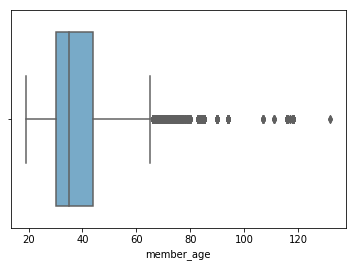

In [23]:
sb.boxplot(x='member_age', data=df, palette='Blues', orient='h')

In [24]:
p=figure(height=200)
p.diamond_cross(x=df.member_age , y=df.duration_sec)
show(p)

In [25]:
np.mean(df.member_age)

37.595212717831934

#### Finding daily number of bike rides 

In [26]:
def transform_axis_fmt(tick_val, pos):
    if tick_val >= 1000:
        val = int(tick_val/1000)
        return '{:d}K'.format(val)
    elif tick_val >= 1000000: 
        val = int(tick_val/1000000)
        return '{:d}M'.format(val)
    else:
        return int(tick_val)

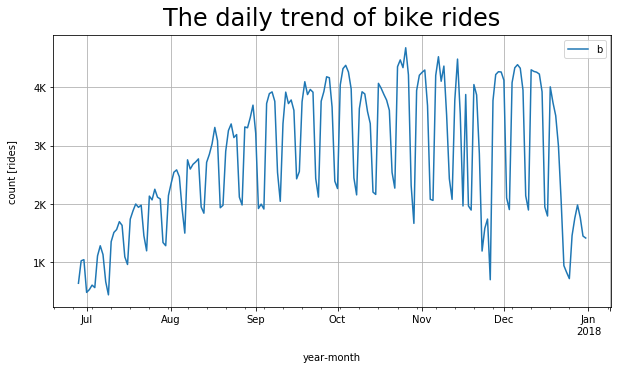

In [27]:
df.groupby(df.start_time.dt.to_period('D')).agg('count')['bike_id'].plot(kind = 'line', figsize = [10, 5])
plt.title('The daily trend of bike rides', fontsize=24, y=1.015)
plt.xlabel('year-month', labelpad=16)
plt.ylabel('count [rides]', labelpad=16)
ax = plt.gca()
ax.yaxis.set_major_formatter(tick.FuncFormatter(transform_axis_fmt))
plt.grid()
plt.legend('bikes')


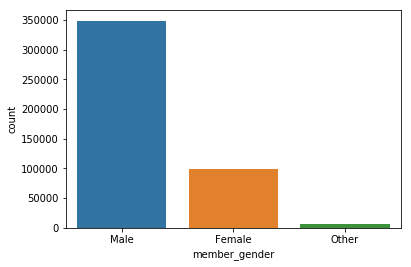

In [29]:
sb.countplot(data = df, x = 'member_gender')

In [30]:
trip_by_weekday_df = df.groupby('start_time_weekday_abbr').agg({'bike_id':'count'})
trip_by_weekday_df['perc'] = (trip_by_weekday_df['bike_id']/trip_by_weekday_df['bike_id'].sum())*100


In [31]:
weekday_index = ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun']

Text(0,0.5,'percentage(%) [rides]')

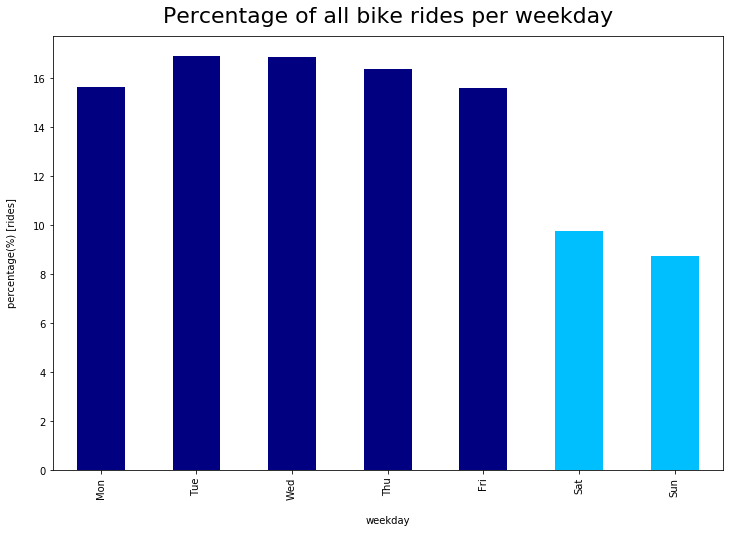

In [32]:
new_color = ['navy', 'navy', 'navy', 'navy', 'navy', 'deepskyblue', 'deepskyblue']
trip_by_weekday_df.reindex(weekday_index)['perc'].plot(kind='bar', color=new_color, figsize=(12,8), legend=False)
plt.title('Percentage of all bike rides per weekday', fontsize=22, y=1.015)
plt.xlabel('weekday', labelpad=16)
plt.ylabel('percentage(%) [rides]', labelpad=16)


#### Age Groups bikers per month

  * Creating age groups of bikers

In [33]:

df['member_age_bins'] = df['member_age'].apply(lambda x: '10 - 20' if 10<x<=20
                                                  else '21 - 30' if 20<x<=30
                                                  else '31 - 40' if 30<x<=40
                                                  else '41 - 50' if 40<x<=50
                                                  else '51 - 60' if 50<x<=60
                                                  else '61 - 70' if 60<=x<=70
                                                  else '71 - 80' if 70<=x<=80
                                                  else '81 - 90' if 80<=x<=90
                                                  else '91 - 100'if 90<=x<=100
                                                  else x)


In [34]:
df.member_age_bins.head(5)

0    31 - 40
1    51 - 60
2        NaN
3        NaN
4    21 - 30
Name: member_age_bins, dtype: object

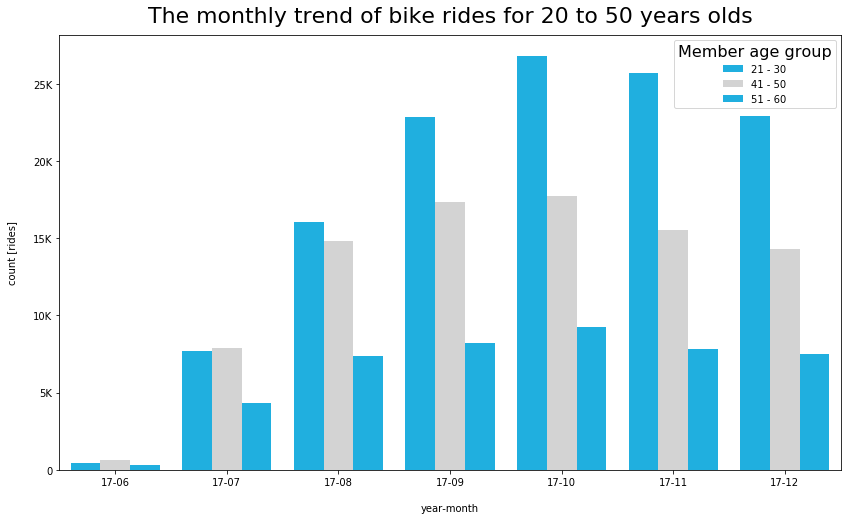

In [35]:
plt.figure(figsize=(14,8))
my_palette = {'21 - 30': 'deepskyblue', '31 - 40': 'navy', '41 - 50': 'lightgrey','51 - 60': 'deepskyblue'}
ax = sb.countplot(x='start_time_year_month_renamed', hue='member_age_bins', palette=my_palette,
                   data=df[df['member_age_bins'].isin(['21 - 30', '31 - 41', '41 - 50', '51 - 60'])].sort_values(by=['start_time_year_month_renamed', 'member_age_bins']))
plt.title('The monthly trend of bike rides for 20 to 50 years olds', fontsize=22, y=1.015)
plt.xlabel('year-month', labelpad=16)
plt.ylabel('count [rides]', labelpad=16)
leg = ax.legend()
leg.set_title('Member age group',prop={'size':16})
ax = plt.gca()
ax.yaxis.set_major_formatter(tick.FuncFormatter(transform_axis_fmt))



In [36]:

trip_by_hour = df.groupby('start_time_hour').agg({'bike_id':'count'}).reset_index()

In [37]:
trip_by_hour['bike_id'] = (trip_by_hour['bike_id']/trip_by_hour['bike_id'].sum())*100

Text(0,0.5,'percentage(%) [rides]')

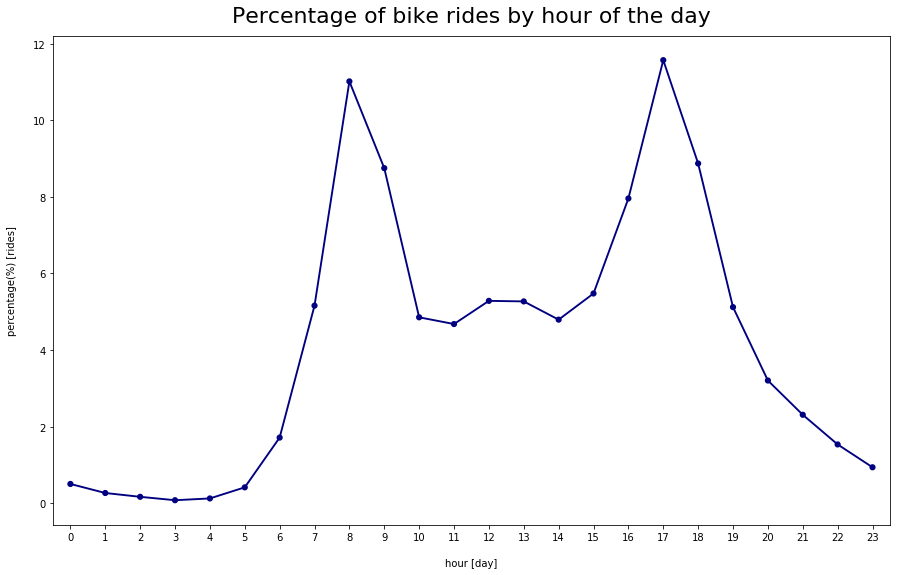

In [38]:
plt.figure(figsize=(15,9))
sb.pointplot(x='start_time_hour', y='bike_id', scale=.7, color='navy', data=trip_by_hour)
plt.title('Percentage of bike rides by hour of the day', fontsize=22, y=1.015)
plt.xlabel('hour [day]', labelpad=16)
plt.ylabel('percentage(%) [rides]', labelpad=16)



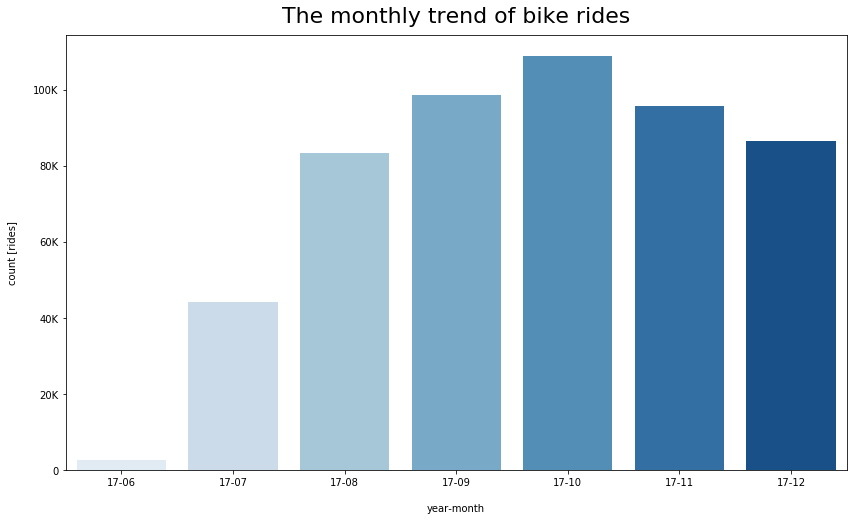

In [39]:
plt.figure(figsize=(14,8))
sb.countplot(x='start_time_year_month_renamed', palette="Blues", 
             data=df.sort_values(by='start_time_year_month_renamed'))
plt.title('The monthly trend of bike rides', fontsize=22, y=1.015)
plt.xlabel('year-month', labelpad=16)
plt.ylabel('count [rides]', labelpad=16)
ax = plt.gca()
ax.yaxis.set_major_formatter(tick.FuncFormatter(transform_axis_fmt))

#### Percentage of all bike rides per group

In [40]:

trip_by_age_df = df.groupby('member_age_bins').agg({'bike_id':'count'})


In [41]:

trip_by_age_df['perc'] = (trip_by_age_df['bike_id']/trip_by_age_df['bike_id'].sum())*100


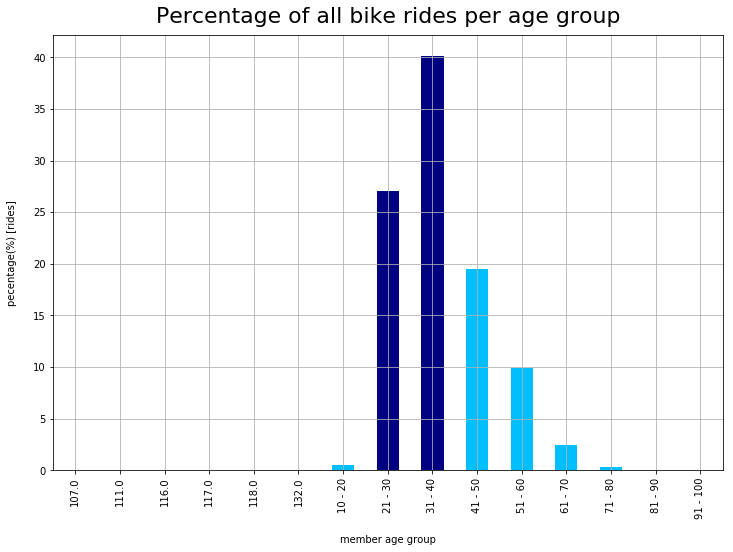

In [42]:

new_color = ['deepskyblue', 'navy', 'navy', 'deepskyblue', 'deepskyblue']
trip_by_age_df['perc'].plot(kind='bar', color=new_color, figsize=(12,8))
plt.title('Percentage of all bike rides per age group', fontsize=22, y=1.015)
plt.xlabel('member age group', labelpad=16)
plt.ylabel('pecentage(%) [rides]', labelpad=16)
plt.grid()


  * count of bike rides of subscribers and customers

In [43]:
count_of_rides_per_user_type = df.groupby('user_type').size().reset_index(name='count')


In [44]:
count_of_rides_per_user_type['count']/len(df)*100

0    21.256494
1    78.743506
Name: count, dtype: float64

In [45]:
user_type_count_per_year_df = df.groupby(["start_time_year_month_renamed", "user_type"]).size().reset_index()


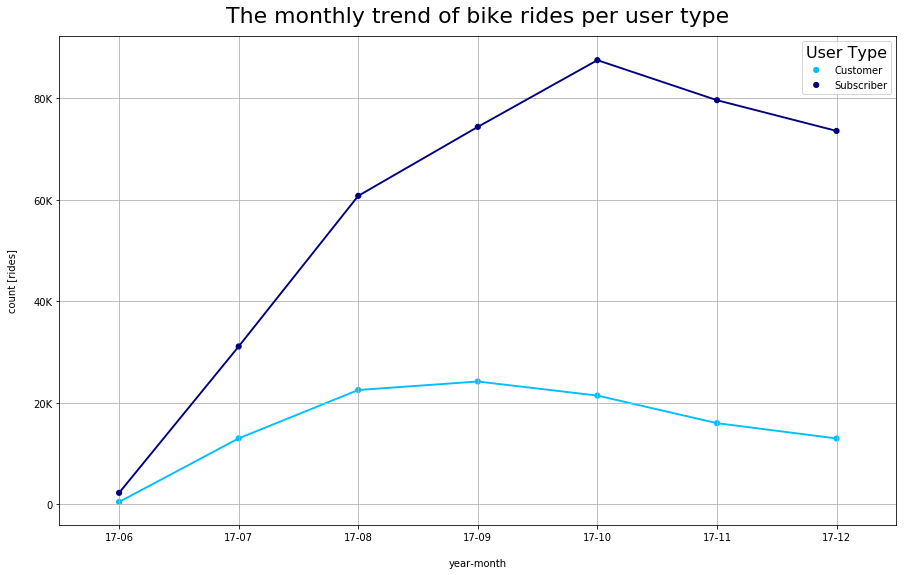

In [46]:

plt.figure(figsize=(15,9))
my_palette = {'Subscriber':'navy', 'Customer':'deepskyblue'}
ax = sb.pointplot(x='start_time_year_month_renamed', y=0, hue='user_type', palette=my_palette, scale=.7, 
                  data=user_type_count_per_year_df)
plt.title('The monthly trend of bike rides per user type', fontsize=22, y=1.015)
plt.xlabel('year-month', labelpad=16)
plt.ylabel('count [rides]', labelpad=16)
leg = ax.legend()
leg.set_title('User Type',prop={'size':16})
ax = plt.gca()
ax.yaxis.set_major_formatter(tick.FuncFormatter(transform_axis_fmt))
plt.grid()


In [47]:
df.start_time_year_month.head(5)

0    2017-12
1    2017-12
2    2017-12
3    2017-12
4    2017-12
Name: start_time_year_month, dtype: object

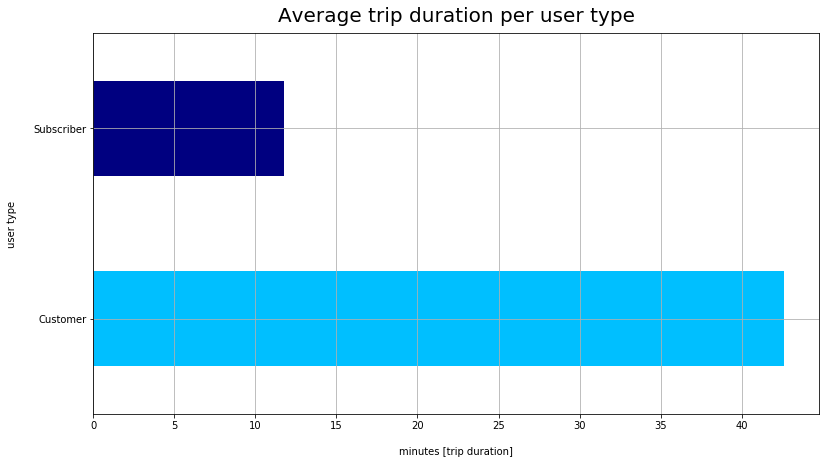

In [48]:
new_color=['deepskyblue', 'navy']
ax = df.groupby('user_type')['duration_min'].mean().plot(kind='barh', color=new_color, figsize=(13,7))
ax.set_title('Average trip duration per user type', fontsize=20, y=1.015)
ax.set_ylabel('user type', labelpad=16)
ax.set_xlabel('minutes [trip duration]', labelpad=16)
plt.grid()

## for i,j in enumerate(duration_min_pr["duration_min"]):
##    ax.text(.7,i,str(round(j,2))+' minutes', weight='bold', ha='left', fontsize=16, color="white")
    

In [49]:
subscriber_age_df = df[df['user_type']=='Subscriber'].groupby(['start_time_year_month_renamed', 'member_age_bins']).agg({'bike_id':'count'}).reset_index()


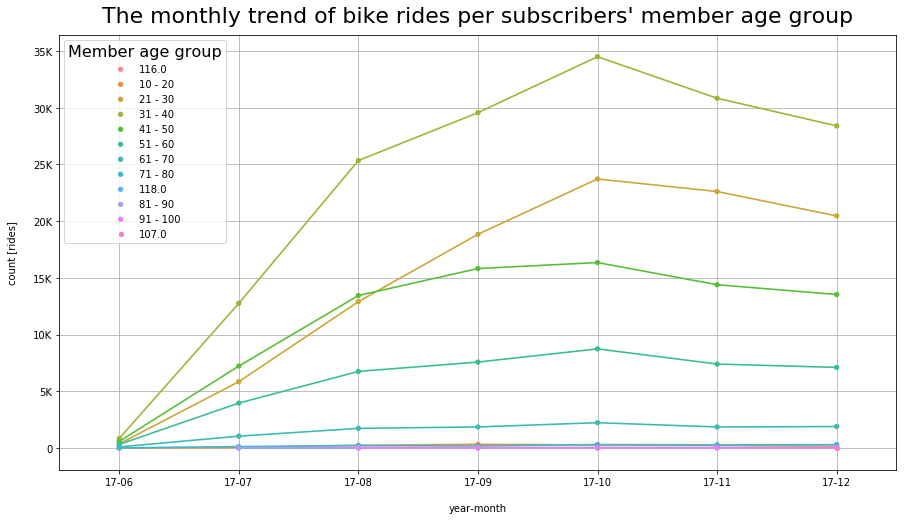

In [50]:
plt.figure(figsize=(15,8))
ax = sb.pointplot(x='start_time_year_month_renamed', y='bike_id', hue='member_age_bins', 
                  scale=.6, data=subscriber_age_df)
plt.title("The monthly trend of bike rides per subscribers' member age group", fontsize=22, y=1.015)
plt.xlabel('year-month', labelpad=16)
plt.ylabel('count [rides]', labelpad=16)
leg = ax.legend()
leg.set_title('Member age group',prop={'size':16})
ax = plt.gca()
ax.yaxis.set_major_formatter(tick.FuncFormatter(transform_axis_fmt))
plt.grid()


In [51]:
customer_age_df = df[df['user_type']=='Customer'].groupby(['start_time_year_month_renamed', 'member_age_bins']).agg({'bike_id':'count'}).reset_index()


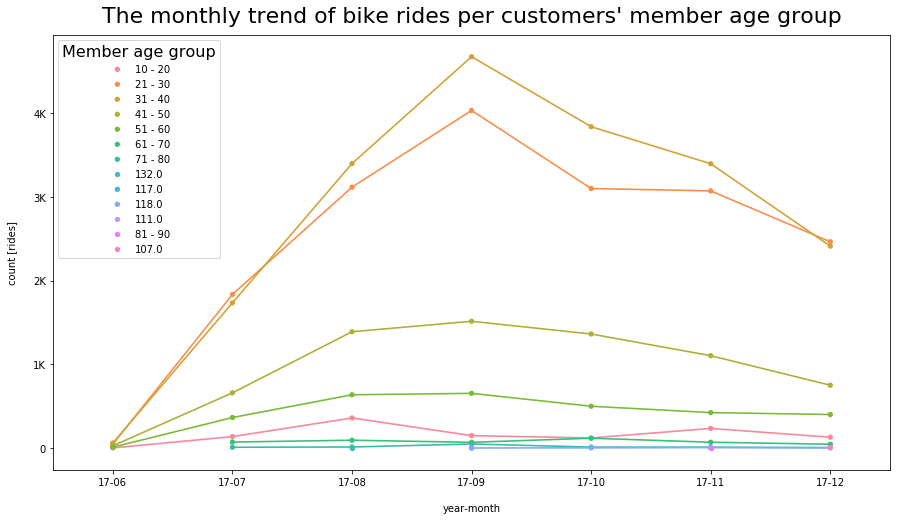

In [52]:
plt.figure(figsize=(15,8))
ax = sb.pointplot(x='start_time_year_month_renamed', y='bike_id', hue='member_age_bins', 
                  scale=.6, data=customer_age_df)
plt.title("The monthly trend of bike rides per customers' member age group", fontsize=22, y=1.015)
plt.xlabel('year-month', labelpad=16)
plt.ylabel('count [rides]', labelpad=16)
leg = ax.legend()
leg.set_title('Member age group',prop={'size':16})
ax = plt.gca()
ax.yaxis.set_major_formatter(tick.FuncFormatter(transform_axis_fmt))

In [53]:
df.distance_miles.describe()

count    519700.000000
mean          0.986163
std           0.627828
min           0.000000
25%           0.559012
50%           0.870071
75%           1.287788
max          42.369292
Name: distance_miles, dtype: float64

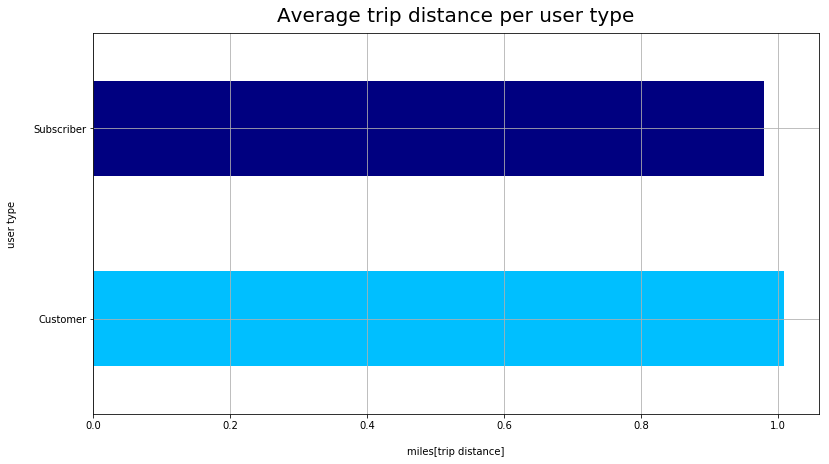

In [54]:
new_color=['deepskyblue', 'navy']
ax = df.groupby('user_type')['distance_miles'].mean().plot(kind='barh', color=new_color, figsize=(13,7))
ax.set_title('Average trip distance per user type', fontsize=20, y=1.015)
ax.set_ylabel('user type', labelpad=16)
ax.set_xlabel('miles[trip distance]', labelpad=16)
plt.grid()


In [55]:
df.groupby('user_type')['distance_miles'].mean()

user_type
Customer      1.009468
Subscriber    0.979873
Name: distance_miles, dtype: float64

In [56]:
df.head(5)

,duration_sec,start_time,end_time,start_station_id,start_station_name,start_station_latitude,start_station_longitude,end_station_id,end_station_name,end_station_latitude,...,start_time_weekday,end_time_weekday,start_time_weekday_abbr,end_time_weekday_abbr,start_time_year_month_renamed,duration_min,distance_km,distance_miles,member_age,member_age_bins
0,80110,2017-12-31 16:57:39.654,2018-01-01 15:12:50.245,74,Laguna St at Hayes St,37.776435,-122.426244,43,San Francisco Public Library (Grove St at Hyde...,37.778768,...,Sunday,Monday,Sun,Mon,17-12,1335.166667,0.942931,0.585910,31.0,31 - 40
1,78800,2017-12-31 15:56:34.842,2018-01-01 13:49:55.617,284,Yerba Buena Center for the Arts (Howard St at ...,37.784872,-122.400876,96,Dolores St at 15th St,37.766210,...,Sunday,Monday,Sun,Mon,17-12,1313.333333,3.069727,1.907439,53.0,51 - 60
2,45768,2017-12-31 22:45:48.411,2018-01-01 11:28:36.883,245,Downtown Berkeley BART,37.870348,-122.267764,245,Downtown Berkeley BART,37.870348,...,Sunday,Monday,Sun,Mon,17-12,762.800000,0.000000,0.000000,NaN,NaN
3,62172,2017-12-31 17:31:10.636,2018-01-01 10:47:23.531,60,8th St at Ringold St,37.774520,-122.409449,5,Powell St BART Station (Market St at 5th St),37.783899,...,Sunday,Monday,Sun,Mon,17-12,1036.200000,1.046622,0.650341,NaN,NaN
4,43603,2017-12-31 14:23:14.001,2018-01-01 02:29:57.571,239,Bancroft Way at Telegraph Ave,37.868813,-122.258764,247,Fulton St at Bancroft Way,37.867789,...,Sunday,Monday,Sun,Mon,17-12,726.716667,0.636339,0.395403,21.0,21 - 30


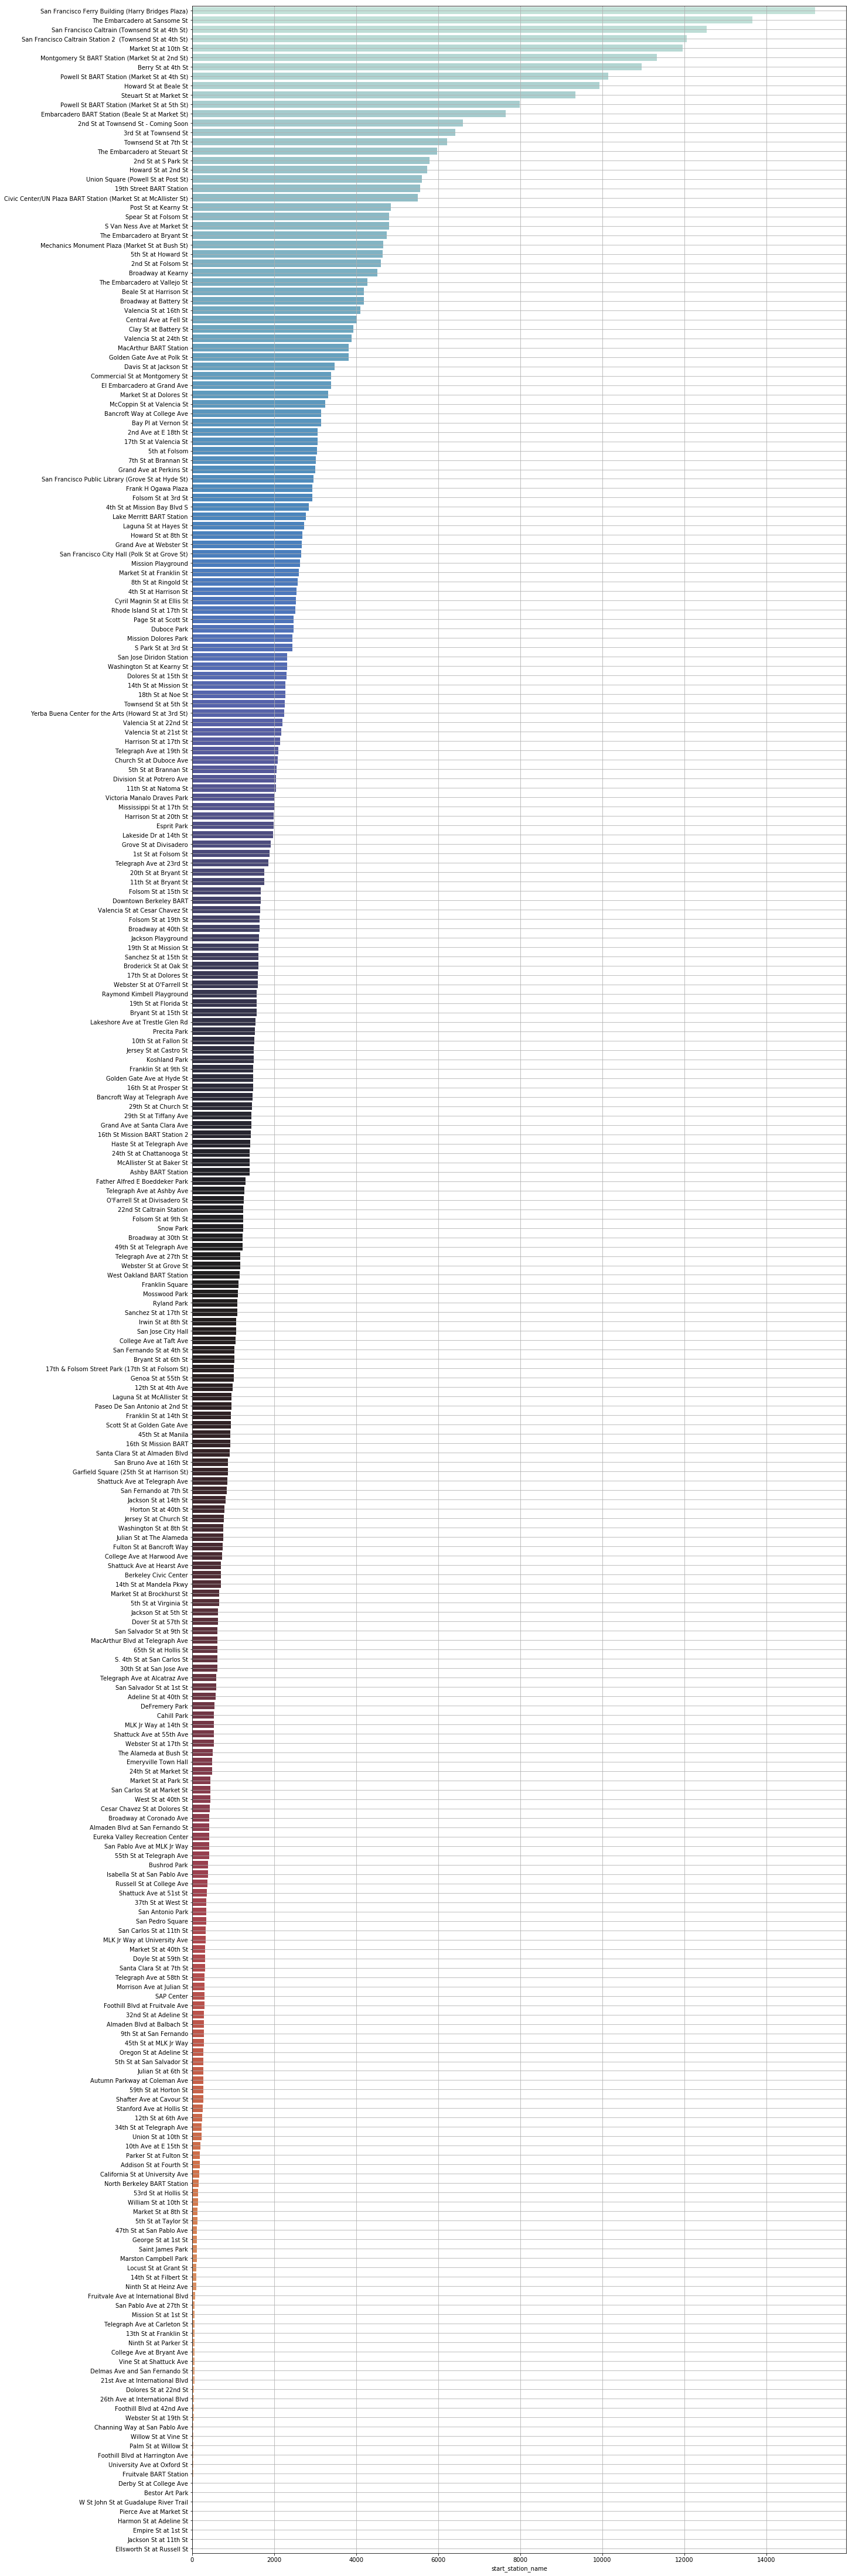

In [57]:
plt.figure(figsize=(20,80))
data=df.start_station_name.value_counts()
sb.barplot(y=data.index, x = data, orient='h',palette='icefire')
plt.grid()

In [58]:

top_50_popular_station = df.groupby(['start_station_name']).size().sort_values(ascending=False)[:50].to_frame().reset_index().start_station_name




In [59]:
print (top_50_popular_station)

0     San Francisco Ferry Building (Harry Bridges Pl...
1                         The Embarcadero at Sansome St
2        San Francisco Caltrain (Townsend St at 4th St)
3     San Francisco Caltrain Station 2  (Townsend St...
4                                  Market St at 10th St
5      Montgomery St BART Station (Market St at 2nd St)
6                                    Berry St at 4th St
7          Powell St BART Station (Market St at 4th St)
8                                 Howard St at Beale St
9                               Steuart St at Market St
10         Powell St BART Station (Market St at 5th St)
11     Embarcadero BART Station (Beale St at Market St)
12                  2nd St at Townsend St - Coming Soon
13                                3rd St at Townsend St
14                                Townsend St at 7th St
15                        The Embarcadero at Steuart St
16                                  2nd St at S Park St
17                                  Howard St at